In [1]:
import pandas as pd
import polars as pl
import numpy as np
from matplotlib import pyplot as plt

import preprocessing as prep
import machine_learning as ml

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, average_precision_score, fbeta_score, confusion_matrix, ConfusionMatrixDisplay

In [2]:
df = pd.read_csv('data/2015-01-02-TOTF.PA-book.csv.gz')

### Prepare features

In [3]:
features = prep.extract_features(df, window=50)

### Tao et al. - Weighted Multilevel Imbalance ###
features["Weighted_Imbalance_decreasing"] = prep.compute_weighted_imbalance(df, weights=[0.1, 0.1, 0.2, 0.2, 0.4], levels=5)
features["Weighted_Imbalance_increasing"] = prep.compute_weighted_imbalance(df, weights=[0.4, 0.2, 0.2, 0.1, 0.1], levels=5)
features["Weighted_Imbalance_constant"] = prep.compute_weighted_imbalance(df, weights=[0.2, 0.2, 0.2, 0.2, 0.2], levels=5)

### Poutré et al. - Rapidity and Specific Event Flows ###
features = prep.compute_rapidity_event_flow_features(df, features, sma_window=10)

### Fabre & Challet - Hawkes memory ###
features = prep.compute_hawkes_and_weighted_flow(df, data=features, etas=[0.1,1.0,10.0], betas=[10,100,1000])

In [4]:
features.replace([np.inf, -np.inf], np.nan, inplace=True)
features = features.fillna(0)

# Clip values to remove extreme outliers
lower_bound = features.quantile(0.001)
upper_bound = features.quantile(0.999)
features = features.clip(lower=lower_bound, upper=upper_bound, axis=1)

### Transformer and OC-SVM

In [5]:
### Transformer Model Hyperparameters
sequence_length = 25
num_features = features.shape[1]
model_dim = 64
representation_dim = 128
num_heads = 4
num_layers = 2
batch_size = 16
epochs = 5
learning_rate = 1e-3

In [6]:
X_train, X_test, scaler = prep.prepare_features(features, seq_length=sequence_length)

In [7]:
data_train_tensor = torch.tensor(X_train, dtype=torch.float32)
data_test_tensor = torch.tensor(X_test, dtype=torch.float32)

train_dataset = TensorDataset(data_train_tensor, data_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
print(f"Training on {len(data_train_tensor)} sequences.")
print(f"Features per sequence: {num_features}")

Training on 448282 sequences.
Features per sequence: 116


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = ml.TransformerAutoencoder(
    num_features=num_features,
    model_dim=model_dim,
    num_heads=num_heads,
    num_layers=num_layers,
    representation_dim=representation_dim,
    sequence_length=sequence_length
)
model = model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

model.train()
for epoch in range(epochs):
    total_loss = 0.0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.4f}")

Using device: cuda
Epoch [1/5], Loss: 0.0031
Epoch [2/5], Loss: 0.0016
Epoch [3/5], Loss: 0.0021
Epoch [4/5], Loss: 0.0024
Epoch [5/5], Loss: 0.0020


In [9]:
# Helper function to process in batches ---
def get_representations_batched(model, data_tensor, batch_size, device):
    """
    Generates representations in batches to avoid CUDA OOM.
    """
    dataset = TensorDataset(data_tensor)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    
    model.eval()
    representations = []
    
    print(f"Extracting representations from {len(data_tensor)} sequences...")
    with torch.no_grad():
        for batch in loader:
            inputs = batch[0].to(device)
            reps = model.get_representation(inputs)
            representations.append(reps.cpu().numpy())
            
    # Concatenate all batches into one large numpy array
    return np.concatenate(representations, axis=0)

Z_train = get_representations_batched(
    model, 
    data_train_tensor, 
    batch_size=1024, 
    device=device
)

print(f"Z_train shape: {Z_train.shape}")

scaler = StandardScaler()
Z_train_scaled = scaler.fit_transform(Z_train)

# nu=0.01 assumes approx 1% of training data might be outliers/noise
oc_svm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.01) 
oc_svm.fit(Z_train_scaled)

Extracting representations from 448282 sequences...
Z_train shape: (448282, 128)


,kernel,'rbf'
,degree,3
,gamma,'auto'
,coef0,0.0
,tol,0.001
,nu,0.01
,shrinking,True
,cache_size,200
,verbose,False
,max_iter,-1


In [10]:
Z_test_normal = get_representations_batched(
    model, 
    data_test_tensor, 
    batch_size=1024, 
    device=device
)

Z_test_normal_scaled = scaler.transform(Z_test_normal)
Z_test_anomalous_scaled = Z_test_normal_scaled * 5.0  # Introduce anomalies by scaling

X_test_final = np.concatenate([Z_test_normal_scaled, Z_test_anomalous_scaled], axis=0)

y_true = np.concatenate([np.zeros(len(Z_test_normal_scaled)), np.ones(len(Z_test_anomalous_scaled))], axis=0)

anomaly_scores = -oc_svm.score_samples(X_test_final)
preds_raw = oc_svm.predict(X_test_final)

y_pred = np.where(preds_raw == -1, 1, 0)

Extracting representations from 192122 sequences...



--- Test Results ---
AUROC: 1.0000 (Ability to distinguish Normal vs Anomaly)
AUPRC: 1.0000 (Precision/Recall balance)
F4-Score: 0.9973 (Recall-weighted score)


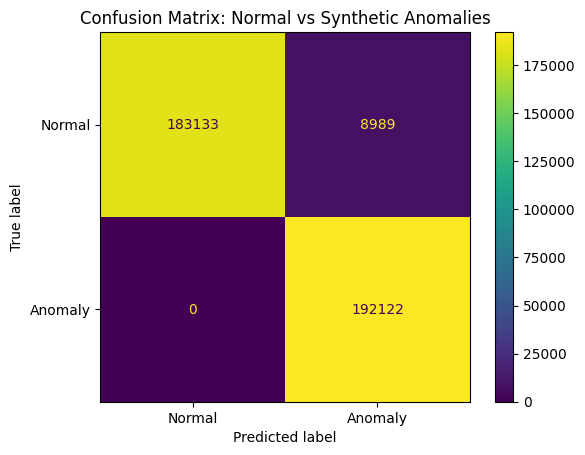

In [11]:
auroc = roc_auc_score(y_true, anomaly_scores)
auprc = average_precision_score(y_true, anomaly_scores)
f4_score = fbeta_score(y_true, y_pred, beta=4)

print("\n--- Test Results ---")
print(f"AUROC: {auroc:.4f} (Ability to distinguish Normal vs Anomaly)")
print(f"AUPRC: {auprc:.4f} (Precision/Recall balance)")
print(f"F4-Score: {f4_score:.4f} (Recall-weighted score)")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Anomaly"])
disp.plot()
plt.title("Confusion Matrix: Normal vs Synthetic Anomalies")
plt.show()

In [ ]:
def calculate_permutation_importance(model, oc_svm, scaler, data_tensor, feature_names, device, n_repeats=5):
    """
    Calculates feature importance by shuffling one feature at a time and measuring
    the shift in Anomaly Scores.
    """
    print("Calculating Baseline Scores...")
    # 1. Get Baseline Scores (Normal Data)
    # We use a subset (first 2048 samples) to keep it fast
    subset_size = 2048
    data_subset = data_tensor[:subset_size].to(device)
    
    model.eval()
    with torch.no_grad():
        z_baseline = model.get_representation(data_subset).cpu().numpy()
    
    z_baseline_scaled = scaler.transform(z_baseline)
    # Score: We use negative score_samples (Higher = More Anomalous)
    baseline_scores = -oc_svm.score_samples(z_baseline_scaled)
    
    importances = []
    
    print(f"Permuting {len(feature_names)} features...")
    
    for i, feature_name in enumerate(feature_names):
        diffs = []
        for _ in range(n_repeats):
            # Clone the data so we don't corrupt the original
            data_permuted = data_subset.clone()
            
            # Shuffle the specific feature across the batch dimension
            # (Batch, Seq_Len, Features) -> Shuffle index 0
            perm_indices = torch.randperm(subset_size)
            data_permuted[:, :, i] = data_permuted[perm_indices, :, i]
            
            # Get new representations and scores
            with torch.no_grad():
                z_perm = model.get_representation(data_permuted).cpu().numpy()
            
            z_perm_scaled = scaler.transform(z_perm)
            perm_scores = -oc_svm.score_samples(z_perm_scaled)
            
            # Measure the Mean Absolute Deviation from baseline
            # How much did the score change?
            score_diff = np.mean(np.abs(perm_scores - baseline_scores))
            diffs.append(score_diff)
        
        importances.append(np.mean(diffs))
        
    return pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# --- Run the Importance Test ---

# 1. Get Feature Names from your dataframe columns
feature_names = features.columns.tolist()

# 2. Calculate
importance_df = calculate_permutation_importance(
    model, 
    oc_svm, 
    scaler, 
    data_test_tensor, # Use the test tensor (Normal data)
    feature_names, 
    device
)

# 3. Sort and Normalize
importance_df = importance_df.sort_values(by='Importance', ascending=False)
# Normalize to 0-100 scale for readability
importance_df['Importance'] = (importance_df['Importance'] / importance_df['Importance'].max()) * 100
top_30_features = importance_df.head(30)

# --- Visualize ---
plt.figure(figsize=(10, 12))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='#2a9d8f')
plt.title('Feature Importance: Contribution to Anomaly Score')
plt.xlabel('Relative Importance Score (Impact on Detection)')
plt.ylabel('Feature Name')
plt.tight_layout()
plt.show()

# Show the top 10 predictors
print("\n--- Top 10 Most Important Features ---")
print(importance_df.head(10))

NameError: name 'features' is not defined